# Libraries
---

In [1]:
# System Libraires
import os
import pickle
import json
import gc # Garbage collection for MPS
import numpy as np
import pandas as pd
from collections import defaultdict
from time import time
import random
from glob import glob
from pathlib import Path
# Pytorch libraries (Machine Learning)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim import Adam
from sklearn.model_selection import train_test_split
# CWT libraries
import pywt
from tqdm import tqdm
# PSD libraries
from scipy.signal import welch
from scipy.interpolate import interp1d
import mne  # For multitaper PSD
from mne.time_frequency import psd_array_multitaper
# Visualization Libraries
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
# TensorFlow Libraries
import keras
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import History

import warnings

DATAFILES_DIR = '../Datafiles'
MODELFILES_DIR = '../Models'
UCIHARFILES_DIR = '../UCI_HAR'
COLLECTIONFILES_DIR = '../data-collections'

# Raw Data Preprocessor
This includes normalization per sample

# TNN Simple Model (Single PSD Band)
This uses per-sample normalization and a single PSD band.
The model itself uses TNN, PSD, and fusion

In [2]:
import json
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from scipy.interpolate import interp1d
from scipy.signal import welch

class IMUSonarFromJSON(Dataset):
    """Dataset for IMU + Ultrasonic with raw + PSD output"""

    cols = [
        'AccelX(g)', 'AccelY(g)', 'AccelZ(g)',
        'GyroX(deg/s)', 'GyroY(deg/s)', 'GyroZ(deg/s)',
        'DistanceLeft(cm)', 'DistanceRight(cm)'
    ]

    def __init__(self, json_file, label_map=None, transform=None, target_length=600, debug=False, add_noise=False, noise_level=0.01):
        with open(json_file, 'r') as f:
            self.samples = json.load(f)

        self.transform = transform
        self.label_map = {v: k for k, v in label_map.items()} if label_map else {}
        self.target_length = target_length
        self.debug = debug

        # New noise params:
        self.add_noise = add_noise
        self.noise_level = noise_level  # e.g., 0.01 std dev

        self.cols = IMUSonarFromJSON.cols

    def __len__(self):
        return len(self.samples)

    def compute_global_stats(self):
        """Run this once before training to get mean/std across entire dataset"""
        all_data = torch.stack([torch.tensor(self._resample_to_uniform(pd.read_csv(item['path'])))
                                for item in self.samples])
        self.global_mean = all_data.mean(dim=(0, 2))  # [8]
        self.global_std = all_data.std(dim=(0, 2))    # [8]

    def _resample_to_uniform(self, df):
        """Resample CSV data to uniform length (C, T)"""
        timestamps = df['Timestamp(ms)'].values.astype(np.float32)
        missing = set(self.cols) - set(df.columns)
        if missing:
            raise ValueError(f"Missing required columns: {missing}")

        signals = df[self.cols].values.astype(np.float32)

        # Remove duplicates
        timestamps, unique_indices = np.unique(timestamps, return_index=True)
        signals = signals[unique_indices]

        # Interpolate to uniform time grid
        uniform_timestamps = np.linspace(timestamps[0], timestamps[-1], num=self.target_length)
        resampled = np.zeros((self.target_length, len(self.cols)), dtype=np.float32)
        for i in range(len(self.cols)):
            interp_func = interp1d(timestamps, signals[:, i], kind='linear', fill_value="extrapolate")
            resampled[:, i] = interp_func(uniform_timestamps)

        if self.debug:
            print("\nPREPROCESSING STEPS:")
            print(f"Pre-normalization mean: {resampled.mean():.4f}, std: {resampled.std():.4f}")

        # Normalize per-sample (column-wise)
        resampled = (resampled - resampled.mean(axis=0)) / (resampled.std(axis=0) + 1e-6)

        if self.add_noise:
            noise = np.random.normal(0, self.noise_level, size=resampled.shape).astype(np.float32)
            resampled += noise

        return resampled.T  # (C, T)

    @staticmethod
    def compute_psd(data, fs=50, nperseg=128, noverlap=64):
        """Compute PSD for (C, T) data"""
        C, T = data.shape
        psd_list = []
        for ch in range(C):
            f, Pxx = welch(data[ch], fs=fs, nperseg=nperseg, noverlap=noverlap)
            psd_list.append(Pxx)
        return np.stack(psd_list, axis=0).astype(np.float32)  # (C, F)

    def __getitem__(self, idx):
        """Return (raw_tensor, psd_tensor, label)"""
        item = self.samples[idx]
        df = pd.read_csv(item['path'])

        # Resample to uniform shape (C, T)
        data = self._resample_to_uniform(df)

        # # Optionally add noise to raw data during training
        # if self.add_noise:
        #     noise = np.random.normal(0, self.noise_level, size=data.shape).astype(np.float32)
        #     data = data + noise

        # Estimate sample frequency for PSD
        total_time_sec = (df['Timestamp(ms)'].iloc[-1] - df['Timestamp(ms)'].iloc[0]) / 1000.0
        fs_est = self.target_length / total_time_sec if total_time_sec > 0 else 50.0

        # Compute PSD (C, F)
        psd = self.compute_psd(data, fs=fs_est)

        # Convert to tensors
        raw_tensor = torch.tensor(data, dtype=torch.float32)
        psd_tensor = torch.tensor(psd, dtype=torch.float32)

        label = self.label_map[item['label']] if self.label_map else item['label']
        label_tensor = torch.tensor(item['label'], dtype=torch.long)
        if item['label'] > 27:
            print(f'Label for {item['path']}: {item['label']}')
        #label_tensor = torch.tensor(item['label'], dtype=torch.long)
        #label_tensor = torch.tensor(self.label_map.get(item['label'], item['label']), dtype=torch.long)
        # print(f'Raw Shape: {raw_tensor.shape}')
        # print(f'PSD Shape: {psd_tensor.shape}')
        # print(f'Label Shape: {label_tensor.shape}')
        # print(f'Label Tensor: {label_tensor}')

        return raw_tensor, psd_tensor, label_tensor

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleIMUSonarNet(nn.Module):
    """
    Simplified model for original samples only
    """
    def __init__(self, num_channels=8, num_classes=5, psd_bins=64, dropout=0.2):
        super().__init__()
        
        # # --- Time domain branch ---
        # self.time_conv = nn.Sequential(
        #     nn.Conv1d(num_channels, 32, kernel_size=5, padding=2),
        #     nn.BatchNorm1d(32),
        #     nn.ReLU(inplace=True),
        #     nn.Conv1d(32, 64, kernel_size=5, padding=2),
        #     nn.BatchNorm1d(64),
        #     nn.ReLU(inplace=True),
        #     nn.AdaptiveAvgPool1d(1)
        # )
        
        # # --- PSD branch ---
        # self.psd_fc = nn.Sequential(
        #     nn.Linear(num_channels * psd_bins, 128),
        #     nn.BatchNorm1d(128),
        #     nn.ReLU(inplace=True),
        #     nn.Dropout(dropout)
        # )
        
        # # --- Fusion and classification ---
        # self.classifier = nn.Sequential(
        #     nn.Linear(64 + 128, 128),  # time features + PSD features
        #     nn.ReLU(inplace=True),
        #     nn.BatchNorm1d(128),
        #     nn.Dropout(dropout),
        #     nn.Linear(128, num_classes)
        # )

        # --- Time domain branch ---
        self.time_conv = nn.Sequential(
            nn.Conv1d(num_channels, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout/3),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout/3),
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool1d(1)
        )
        
        # --- PSD branch ---
        self.psd_fc = nn.Sequential(
            nn.Linear(num_channels * psd_bins, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout/2)
        )
        
        # --- Fusion and classification ---
        self.classifier = nn.Sequential(
            nn.Linear(256 + 128, 256),  # More capacity
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout/2),
            nn.Linear(128, num_classes)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)
    
    def forward(self, raw_x, psd_x):
        # Time domain processing
        time_features = self.time_conv(raw_x).squeeze(-1)
        
        # PSD processing
        psd_flat = psd_x.view(psd_x.size(0), -1)
        psd_features = self.psd_fc(psd_flat)
        
        # Concatenate and classify
        combined = torch.cat([time_features, psd_features], dim=1)
        logits = self.classifier(combined)
        
        return logits

In [4]:
import os
import torch
import numpy as np
import random
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from time import time
import torch.nn as nn
import json

# Seeds
torch.manual_seed(42); np.random.seed(42); random.seed(42)

# Device
device = torch.device("mps" if torch.backends.mps.is_available() else 
                      "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------- Data ----------------
with open(f"{DATAFILES_DIR}/compressed_label_map.json", 'r') as f:
    label_map = json.load(f)

train_dataset = IMUSonarFromJSON(
    f"{DATAFILES_DIR}/train_split.json",
    label_map=label_map,
    target_length=600,
    noise_level=0.001,
    # window_length=128,
    # stride=32,          # lots of windows
    add_noise=True      # enable training-time augmentation
)
test_dataset = IMUSonarFromJSON(
    f"{DATAFILES_DIR}/test_split.json",
    label_map=label_map,
    target_length=600,
    # window_length=128,
    # stride=32,   # lots of windows
    add_noise=False
)

# Compute global stats on TRAIN ONLY, then share with TEST
train_dataset.compute_global_stats()
test_dataset.global_mean = train_dataset.global_mean.clone()
test_dataset.global_std  = train_dataset.global_std.clone()

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=0, drop_last=False)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=0, drop_last=False)

# ---------------- Model ----------------
sample_raw, sample_psd, _ = train_dataset[0]
num_channels = sample_raw.shape[0]
psd_bins = sample_psd.shape[1]
num_classes = len(label_map)

model = SimpleIMUSonarNet(
    num_channels=num_channels,
    num_classes=num_classes,
    psd_bins=psd_bins,
    dropout=0.2               # slightly higher dropout to curb overfit
).to(device)

# ---------------- Train loop ----------------
epochs = 50
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)  # stronger label smoothing
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

# Early stopping
best_val_acc = 0.0
patience = 5
no_improve_epochs = 0
best_state = None

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    epoch_start = time()
    
    for raw_batch, psd_batch, labels in train_loader:
        raw_batch = raw_batch.to(device)
        psd_batch = psd_batch.to(device)
        labels    = labels.to(device).long()

        optimizer.zero_grad()
        outputs = model(raw_batch, psd_batch)
        loss = criterion(outputs, labels)
        loss.backward()
        # gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total   += labels.size(0)
    
    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for raw_batch, psd_batch, labels in test_loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels    = labels.to(device).long()
            
            outputs = model(raw_batch, psd_batch)
            val_loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(labels).sum().item()
            val_total   += labels.size(0)
    
    # Metrics
    train_loss = running_loss / len(train_loader)
    train_acc  = correct / total
    val_loss   = val_loss / len(test_loader)
    val_acc    = val_correct / val_total
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Scheduler step
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch + 1}/{epochs} - {time() - epoch_start:.1f}s | " \
            f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | " \
            f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    
#     # Early stopping
#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         no_improve_epochs = 0
#         best_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
#     else:
#         no_improve_epochs += 1
#         if no_improve_epochs >= patience:
#             print(f"⏹ Early stopping at epoch {epoch+1} (best val acc {best_val_acc:.4f})")
#             break

# # Restore best model
# if best_state is not None:
#     model.load_state_dict(best_state)

# ---------------- Final evaluation ----------------
def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for raw_batch, psd_batch, labels in loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels    = labels.to(device).long()
            outputs = model(raw_batch, psd_batch)
            total_loss += criterion(outputs, labels).item() * raw_batch.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total   += labels.size(0)
    return total_loss / total, correct / total

train_loss, train_acc = evaluate(model, train_loader)
test_loss,  test_acc  = evaluate(model, test_loader)

print('Final Results:')
print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')
print(f'Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}')

Using device: mps
Epoch 1/50 - 2.1s | Train Loss: 2.5521 Acc: 0.2034 | Val Loss: 2.0818 Acc: 0.2810
Epoch 2/50 - 1.2s | Train Loss: 1.6769 Acc: 0.4559 | Val Loss: 1.6349 Acc: 0.4876
Epoch 3/50 - 1.2s | Train Loss: 1.3481 Acc: 0.6054 | Val Loss: 1.4506 Acc: 0.5289
Epoch 4/50 - 1.1s | Train Loss: 1.1531 Acc: 0.6740 | Val Loss: 1.3086 Acc: 0.5537
Epoch 5/50 - 1.2s | Train Loss: 1.0024 Acc: 0.7132 | Val Loss: 1.2460 Acc: 0.6033
Epoch 6/50 - 1.2s | Train Loss: 0.8936 Acc: 0.7794 | Val Loss: 1.1600 Acc: 0.6694
Epoch 7/50 - 1.1s | Train Loss: 0.8074 Acc: 0.7941 | Val Loss: 1.2016 Acc: 0.6529
Epoch 8/50 - 1.1s | Train Loss: 0.7165 Acc: 0.8382 | Val Loss: 1.1603 Acc: 0.6446
Epoch 9/50 - 1.1s | Train Loss: 0.6726 Acc: 0.8480 | Val Loss: 1.1886 Acc: 0.6364
Epoch 10/50 - 1.1s | Train Loss: 0.6251 Acc: 0.8824 | Val Loss: 1.2561 Acc: 0.6198
Epoch 11/50 - 1.2s | Train Loss: 0.5330 Acc: 0.9289 | Val Loss: 1.2193 Acc: 0.6364
Epoch 12/50 - 1.2s | Train Loss: 0.4950 Acc: 0.9363 | Val Loss: 1.2012 Acc: 0.

## Dataset Wide normalization
This normalization is done dataset-wide, and each channel is adjusted differently, mainly to clamp ultrasonic data

In [5]:
import json
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from scipy.interpolate import interp1d
from scipy.signal import welch

class WideNormalizationIMUSonarFromJSON(IMUSonarFromJSON):
    """Dataset for IMU + Ultrasonic with raw + PSD output
    includes dataset -ide normalization"""

    def compute_global_stats(self):
        """Compute mean/std over raw resampled data (no normalization, no aug)."""
        tensors = []
        for item in self.samples:
            df = pd.read_csv(item['path'])
    
            # --- identical resampling as in _resample_to_uniform, but NO normalization/aug ---
            timestamps = df['Timestamp(ms)'].values.astype(np.float32)
            missing = set(self.cols) - set(df.columns)
            if missing:
                raise ValueError(f"Missing required columns: {missing}")
    
            signals = df[self.cols].values.astype(np.float32)
    
            # Remove duplicates
            timestamps, unique_indices = np.unique(timestamps, return_index=True)
            signals = signals[unique_indices]
    
            # Interpolate to uniform time grid
            uniform_timestamps = np.linspace(timestamps[0], timestamps[-1], num=self.target_length)
            resampled = np.zeros((self.target_length, len(self.cols)), dtype=np.float32)
            for i in range(len(self.cols)):
                interp_func = interp1d(timestamps, signals[:, i], kind='linear', fill_value="extrapolate")
                resampled[:, i] = interp_func(uniform_timestamps)
    
            # (C, T) — crucially, do NOT normalize or augment here
            tensors.append(torch.tensor(resampled.T, dtype=torch.float32))
    
        all_data = torch.stack(tensors, dim=0)  # (N, C, T)
        self.global_mean = all_data.mean(dim=(0, 2))  # [C]
        self.global_std  = all_data.std(dim=(0, 2))   # [C]

    def _augment_raw(self, raw, noise_level=0.001, scale_range=(0.98,1.02),
                     mask_prob=0.05, jitter_std=0.005):
        """Augment a single sample in (C, T)"""
        if isinstance(raw, np.ndarray):
            raw = torch.tensor(raw, dtype=torch.float32)
    
        C, T = raw.shape
        augmented = raw.clone()
    
        imu_channels = list(range(6))
        sonar_channels = [6,7]
    
        # Gaussian noise
        noise = torch.randn(len(imu_channels), T) * noise_level
        augmented[imu_channels,:] += noise
    
        # Small temporal scaling
        scale = torch.empty(1).uniform_(*scale_range)
        augmented[imu_channels,:] *= scale
    
        # Small amplitude jitter
        jitter = 1.0 + torch.randn(len(imu_channels), T) * jitter_std
        augmented[imu_channels,:] *= jitter
    
        # Random masking
        mask = (torch.rand(len(imu_channels), T) < mask_prob)
        augmented[imu_channels,:][mask] = 0.0
    
        # Clamp sonar
        augmented[sonar_channels,:] = torch.clamp(augmented[sonar_channels,:], 0.0, 1.0)
    
        return augmented

    def _augment_raw_normalized(self, raw, noise_level=0.01, scale_range=(0.98, 1.02),
                 mask_prob=0.01, jitter_std=0.01):
        """Augment a single sample in (C, T) for normalized data"""
        if isinstance(raw, np.ndarray):
            raw = torch.tensor(raw, dtype=torch.float32)
    
        C, T = raw.shape
        augmented = raw.clone()

        self.accel_channels = [0,1,2]
        self.gyro_channels = [3,4,5]
        self.sonar_channels = [6,7]
    
        # Gaussian noise - increased for normalized scale
        noise = torch.randn(len(self.accel_channels) + len(self.gyro_channels), T) * noise_level
        augmented[self.accel_channels + self.gyro_channels,:] += noise
    
        # Temporal scaling - wider range for normalized data
        scale = torch.empty(1).uniform_(*scale_range)
        augmented[self.accel_channels + self.gyro_channels,:] *= scale
    
        # Amplitude jitter - increased for normalized scale
        jitter = 1.0 + torch.randn(len(self.accel_channels) + len(self.gyro_channels), T) * jitter_std
        augmented[self.accel_channels + self.gyro_channels,:] *= jitter
    
        # Random masking - slightly increased
        mask = (torch.rand(len(self.accel_channels) + len(self.gyro_channels), T) < mask_prob)
        augmented[self.accel_channels + self.gyro_channels,:][mask] = 0.0
    
        # Clamp sonar - remove or adjust for normalized data
        # augmented[self.sonar_channels,:] = torch.clamp(augmented[self.sonar_channels,:], -3.0, 3.0)
        # Consider removing clamping entirely for normalized data
    
        return augmented

    def _resample_to_uniform(self, df):
        """Resample CSV data to uniform length (C, T)"""
        timestamps = df['Timestamp(ms)'].values.astype(np.float32)
        missing = set(self.cols) - set(df.columns)
        if missing:
            raise ValueError(f"Missing required columns: {missing}")

        signals = df[self.cols].values.astype(np.float32)

        # Remove duplicates
        timestamps, unique_indices = np.unique(timestamps, return_index=True)
        signals = signals[unique_indices]

        # Interpolate to uniform time grid
        uniform_timestamps = np.linspace(timestamps[0], timestamps[-1], num=self.target_length)
        resampled = np.zeros((self.target_length, len(self.cols)), dtype=np.float32)
        for i in range(len(self.cols)):
            interp_func = interp1d(timestamps, signals[:, i], kind='linear', fill_value="extrapolate")
            resampled[:, i] = interp_func(uniform_timestamps)

        if self.debug:
            print("\nPREPROCESSING STEPS:")
            print(f"Pre-normalization mean: {resampled.mean():.4f}, std: {resampled.std():.4f}")

        # Global or per-sample normalization
        if hasattr(self, "global_mean") and hasattr(self, "global_std"):
            resampled = (resampled - self.global_mean.numpy()) / (self.global_std.numpy() + 1e-6)
        else:
            resampled = (resampled - resampled.mean(axis=0)) / (resampled.std(axis=0) + 1e-6)

        if self.add_noise and torch.rand(1) < 0.5:
            resampled = self._augment_raw_normalized(resampled.T).T  # augment in (C, T), return to (T, C) before transpose

        return resampled.T  # (C, T)

    def __getitem__(self, idx):
        """Return (raw_tensor, psd_tensor, label)"""
        item = self.samples[idx]
        df = pd.read_csv(item['path'])

        # Resample to uniform shape (C, T)
        data = self._resample_to_uniform(df)

        # Estimate sample frequency for PSD
        total_time_sec = (df['Timestamp(ms)'].iloc[-1] - df['Timestamp(ms)'].iloc[0]) / 1000.0
        fs_est = self.target_length / total_time_sec if total_time_sec > 0 else 50.0

        # Compute PSD (C, F)
        psd = self.compute_psd(data, fs=fs_est)

        # Convert to tensors
        #raw_tensor = torch.tensor(data, dtype=torch.float32)
        if isinstance(data, np.ndarray): raw_tensor = torch.tensor(data, dtype=torch.float32)
        else: raw_tensor = data
        psd_tensor = torch.tensor(psd, dtype=torch.float32)

        label = self.label_map[item['label']] if self.label_map else item['label']
        label_tensor = torch.tensor(item['label'], dtype=torch.long)
        if item['label'] > 27:
            print(f'Label for {item["path"]}: {item["label"]}')

        return raw_tensor, psd_tensor, label_tensor

In [183]:
import json
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from scipy.interpolate import interp1d
from scipy.signal import welch

class WideNormalizationPerChannelIMUSonarFromJSON(IMUSonarFromJSON):
    """Dataset for IMU + Ultrasonic with raw + PSD output
    includes dataset-wide normalization with sensor grouping"""

    def __init__(self, json_file, label_map=None, transform=None,
                 target_length=600, window_length=128, stride=64,
                 debug=False, add_noise=False, noise_level=0.01):
        with open(json_file, 'r') as f:
            self.samples = json.load(f)

        self.transform = transform
        self.label_map = {v: k for k, v in label_map.items()} if label_map else {}
        self.target_length = target_length
        self.window_length = window_length
        self.stride = stride
        self.debug = debug
        self.add_noise = add_noise
        self.noise_level = noise_level

        # Define sensor channel groups
        self.cols = IMUSonarFromJSON.cols
        self.accel_channels = [0, 1, 2]    # First 3 channels
        self.gyro_channels = [3, 4, 5]     # Next 3 channels  
        self.sonar_channels = [6, 7]       # Last 2 channels

        # Build window index
        self.window_index = []
        for i, item in enumerate(self.samples):
            T = self.target_length
            if T < self.window_length:
                self.window_index.append((i, 0, T))
            else:
                for start in range(0, T - self.window_length + 1, self.stride):
                    end = start + self.window_length
                    self.window_index.append((i, start, end))

    def compute_global_stats(self):
        """Compute mean/std over raw resampled data for each sensor group"""
        tensors = []
        for item in self.samples:
            df = pd.read_csv(item['path'])
            
            # Identical resampling as in _resample_to_uniform, but NO normalization/aug
            timestamps = df['Timestamp(ms)'].values.astype(np.float32)
            signals = df[self.cols].values.astype(np.float32)

            timestamps, unique_indices = np.unique(timestamps, return_index=True)
            signals = signals[unique_indices]

            uniform_timestamps = np.linspace(timestamps[0], timestamps[-1], num=self.target_length)
            resampled = np.zeros((self.target_length, len(self.cols)), dtype=np.float32)
            for i in range(len(self.cols)):
                interp_func = interp1d(timestamps, signals[:, i], kind='linear', fill_value="extrapolate")
                resampled[:, i] = interp_func(uniform_timestamps)

            tensors.append(torch.tensor(resampled.T, dtype=torch.float32))

        all_data = torch.stack(tensors, dim=0)  # (N, C, T)
        
        # Calculate statistics for each sensor group
        self.global_mean = all_data.mean(dim=(0, 2))  # [C] - per channel mean
        self.global_std = all_data.std(dim=(0, 2))    # [C] - per channel std
        
        # # Calculate group statistics (mean of means, mean of stds for each group)
        # self.accel_mean = self.global_mean[self.accel_channels].mean()
        # self.accel_std = self.global_std[self.accel_channels].mean()
        
        # self.gyro_mean = self.global_mean[self.gyro_channels].mean() 
        # self.gyro_std = self.global_std[self.gyro_channels].mean()
        
        # self.sonar_mean = self.global_mean[self.sonar_channels].mean()
        # self.sonar_std = self.global_std[self.sonar_channels].mean()

    def _apply_sensor_group_normalization(self, data):
        """Apply sensor group normalization (Strategy 1)"""
        # Convert to numpy if it's a tensor
        if torch.is_tensor(data):
            data = data.numpy()
            
        normalized = data.copy()
        
        # Convert tensor stats to numpy for compatibility
        accel_mean = self.accel_mean.item() if torch.is_tensor(self.accel_mean) else self.accel_mean
        accel_std = self.accel_std.item() if torch.is_tensor(self.accel_std) else self.accel_std
        gyro_mean = self.gyro_mean.item() if torch.is_tensor(self.gyro_mean) else self.gyro_mean
        gyro_std = self.gyro_std.item() if torch.is_tensor(self.gyro_std) else self.gyro_std
        sonar_mean = self.sonar_mean.item() if torch.is_tensor(self.sonar_mean) else self.sonar_mean
        sonar_std = self.sonar_std.item() if torch.is_tensor(self.sonar_std) else self.sonar_std
        
        # Normalize accelerometer channels as a group
        normalized[self.accel_channels] = (normalized[self.accel_channels] - accel_mean) / (accel_std + 1e-6)
        
        # Normalize gyroscope channels as a group  
        normalized[self.gyro_channels] = (normalized[self.gyro_channels] - gyro_mean) / (gyro_std + 1e-6)
        
        # Normalize sonar channels as a group
        normalized[self.sonar_channels] = (normalized[self.sonar_channels] - sonar_mean) / (sonar_std + 1e-6)
        
        return torch.tensor(normalized, dtype=torch.float32)

    def _apply_per_channel_normalization(self, data):
        """Apply per-channel normalization (Strategy 2) - MOST LIKELY TO WIN"""
        # Convert to tensor first
        if isinstance(data, np.ndarray):
            data = torch.tensor(data, dtype=torch.float32)
            
        normalized = data.clone()
        
        # Normalize each channel independently using its own statistics
        for i in range(data.shape[0]):
            normalized[i] = (normalized[i] - self.global_mean[i]) / (self.global_std[i] + 1e-6)
        
        return normalized

    def _augment_raw(self, raw, noise_level=0.002, scale_range=(0.98,1.02),
                     mask_prob=0.05, jitter_std=0.01):
        """Augment a single sample in (C, T)"""
        if isinstance(raw, np.ndarray):
            raw = torch.tensor(raw, dtype=torch.float32)

        C, T = raw.shape
        augmented = raw.clone()

        # Gaussian noise
        noise = torch.randn(len(self.accel_channels) + len(self.gyro_channels), T) * noise_level
        augmented[self.accel_channels + self.gyro_channels,:] += noise

        # Small temporal scaling
        scale = torch.empty(1).uniform_(*scale_range)
        augmented[self.accel_channels + self.gyro_channels,:] *= scale

        # Small amplitude jitter
        jitter = 1.0 + torch.randn(len(self.accel_channels) + len(self.gyro_channels), T) * jitter_std
        augmented[self.accel_channels + self.gyro_channels,:] *= jitter

        # Random masking
        mask = (torch.rand(len(self.accel_channels) + len(self.gyro_channels), T) < mask_prob)
        augmented[self.accel_channels + self.gyro_channels,:][mask] = 0.0

        # Clamp sonar
        augmented[self.sonar_channels,:] = torch.clamp(augmented[self.sonar_channels,:], 0.0, 1.0)

        return augmented

    def _resample_to_uniform(self, df):
        """Resample CSV data to uniform length (C, T) - NO NORMALIZATION HERE"""
        timestamps = df['Timestamp(ms)'].values.astype(np.float32)
        signals = df[self.cols].values.astype(np.float32)

        # Remove duplicates
        timestamps, unique_indices = np.unique(timestamps, return_index=True)
        signals = signals[unique_indices]

        # Interpolate to uniform time grid
        uniform_timestamps = np.linspace(timestamps[0], timestamps[-1], num=self.target_length)
        resampled = np.zeros((self.target_length, len(self.cols)), dtype=np.float32)
        for i in range(len(self.cols)):
            interp_func = interp1d(timestamps, signals[:, i], kind='linear', fill_value="extrapolate")
            resampled[:, i] = interp_func(uniform_timestamps)

        return resampled.T  # (C, T) - RAW, unnormalized data

    def compute_psd(self, data, fs=50):
        """Compute PSD for (C, T) data"""
        C, T = data.shape
        nperseg = min(self.window_length, T)
        noverlap = nperseg // 2
        
        psd_list = []
        for ch in range(C):
            f, Pxx = welch(data[ch], fs=fs, nperseg=nperseg, noverlap=noverlap)
            psd_list.append(Pxx)
        return np.stack(psd_list, axis=0).astype(np.float32)

    def __getitem__(self, idx):
        sample_idx, start, end = self.window_index[idx]
        item = self.samples[sample_idx]
        df = pd.read_csv(item['path'])

        # Resample to get raw data (C, T)
        full_data = self._resample_to_uniform(df)
        data = full_data[:, start:end]  # Slice the window

        # Apply sensor group normalization (STRATEGY 1)
        #data = self._apply_sensor_group_normalization(data)
        data = self._apply_per_channel_normalization(data)

        # Apply augmentation if enabled (after normalization)
        if self.add_noise and torch.rand(1) < 0.5:
            data = self._augment_raw(data)

        # Estimate sample frequency for PSD
        total_time_sec = (df['Timestamp(ms)'].iloc[-1] - df['Timestamp(ms)'].iloc[0]) / 1000.0
        fs_est = self.target_length / total_time_sec if total_time_sec > 0 else 50.0

        # Compute PSD
        psd = self.compute_psd(data.numpy(), fs=fs_est)

        return data, torch.tensor(psd, dtype=torch.float32), torch.tensor(item['label'], dtype=torch.long)

In [6]:
import os
import torch
import numpy as np
import random
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from time import time
import torch.nn as nn
import json

# Seeds
torch.manual_seed(42); np.random.seed(42); random.seed(42)

# Device
device = torch.device("mps" if torch.backends.mps.is_available() else 
                      "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------- Data ----------------
with open(f"{DATAFILES_DIR}/compressed_label_map.json", 'r') as f:
    label_map = json.load(f)

train_dataset = WideNormalizationIMUSonarFromJSON(
    f"{DATAFILES_DIR}/train_split.json",
    label_map=label_map,
    target_length=600,
    noise_level=0.001,
    # window_length=128,
    # stride=32,          # lots of windows
    add_noise=True      # enable training-time augmentation
)
test_dataset = WideNormalizationIMUSonarFromJSON(
    f"{DATAFILES_DIR}/test_split.json",
    label_map=label_map,
    target_length=600,
    # window_length=128,
    # stride=32,   # lots of windows
    add_noise=False
)

# Compute global stats on TRAIN ONLY, then share with TEST
train_dataset.compute_global_stats()
test_dataset.global_mean = train_dataset.global_mean.clone()
test_dataset.global_std  = train_dataset.global_std.clone()
# Per sensor stats
# test_dataset.accel_mean = train_dataset.accel_mean
# test_dataset.accel_std = train_dataset.accel_std
# test_dataset.gyro_mean = train_dataset.gyro_mean
# test_dataset.gyro_std = train_dataset.gyro_std  
# test_dataset.sonar_mean = train_dataset.sonar_mean
# test_dataset.sonar_std = train_dataset.sonar_std

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=0, drop_last=False)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=0, drop_last=False)

# ---------------- Model ----------------
sample_raw, sample_psd, _ = train_dataset[0]
num_channels = sample_raw.shape[0]
psd_bins = sample_psd.shape[1]
num_classes = len(label_map)

model = SimpleIMUSonarNet(
    num_channels=num_channels,
    num_classes=num_classes,
    psd_bins=psd_bins,
    dropout=0.2               # slightly higher dropout to curb overfit
).to(device)

# ---------------- Train loop ----------------
epochs = 50
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)  # stronger label smoothing
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

# Early stopping
best_val_acc = 0.0
patience = 5
no_improve_epochs = 0
best_state = None

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    epoch_start = time()
    
    for raw_batch, psd_batch, labels in train_loader:
        raw_batch = raw_batch.to(device)
        psd_batch = psd_batch.to(device)
        labels    = labels.to(device).long()

        optimizer.zero_grad()
        outputs = model(raw_batch, psd_batch)
        loss = criterion(outputs, labels)
        loss.backward()
        # gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total   += labels.size(0)
    
    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for raw_batch, psd_batch, labels in test_loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels    = labels.to(device).long()
            
            outputs = model(raw_batch, psd_batch)
            val_loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(labels).sum().item()
            val_total   += labels.size(0)
    
    # Metrics
    train_loss = running_loss / len(train_loader)
    train_acc  = correct / total
    val_loss   = val_loss / len(test_loader)
    val_acc    = val_correct / val_total
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Scheduler step
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch + 1}/{epochs} - {time() - epoch_start:.1f}s | " \
            f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | " \
            f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    
#     # Early stopping
#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         no_improve_epochs = 0
#         best_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
#     else:
#         no_improve_epochs += 1
#         if no_improve_epochs >= patience:
#             print(f"⏹ Early stopping at epoch {epoch+1} (best val acc {best_val_acc:.4f})")
#             break

# # Restore best model
# if best_state is not None:
#     model.load_state_dict(best_state)

# ---------------- Final evaluation ----------------
def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for raw_batch, psd_batch, labels in loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels    = labels.to(device).long()
            outputs = model(raw_batch, psd_batch)
            total_loss += criterion(outputs, labels).item() * raw_batch.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total   += labels.size(0)
    return total_loss / total, correct / total

train_loss, train_acc = evaluate(model, train_loader)
test_loss,  test_acc  = evaluate(model, test_loader)

print('Final Results:')
print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')
print(f'Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}')

Using device: mps
Epoch 1/50 - 1.3s | Train Loss: 2.2215 Acc: 0.3113 | Val Loss: 1.6636 Acc: 0.4380
Epoch 2/50 - 1.3s | Train Loss: 1.5661 Acc: 0.5196 | Val Loss: 1.3167 Acc: 0.6281
Epoch 3/50 - 1.2s | Train Loss: 1.2353 Acc: 0.6250 | Val Loss: 1.1501 Acc: 0.6694
Epoch 4/50 - 1.2s | Train Loss: 1.0741 Acc: 0.6887 | Val Loss: 1.1480 Acc: 0.6612
Epoch 5/50 - 1.3s | Train Loss: 1.0097 Acc: 0.6985 | Val Loss: 1.0302 Acc: 0.6777
Epoch 6/50 - 1.2s | Train Loss: 0.8919 Acc: 0.7672 | Val Loss: 0.9878 Acc: 0.7603
Epoch 7/50 - 1.3s | Train Loss: 0.8649 Acc: 0.7745 | Val Loss: 1.0145 Acc: 0.7190
Epoch 8/50 - 1.2s | Train Loss: 0.7938 Acc: 0.7966 | Val Loss: 1.0453 Acc: 0.7603
Epoch 9/50 - 1.2s | Train Loss: 0.7447 Acc: 0.8382 | Val Loss: 1.0172 Acc: 0.7438
Epoch 10/50 - 1.2s | Train Loss: 0.7329 Acc: 0.8137 | Val Loss: 0.9465 Acc: 0.7686
Epoch 11/50 - 1.2s | Train Loss: 0.7007 Acc: 0.8309 | Val Loss: 1.0797 Acc: 0.7273
Epoch 12/50 - 1.2s | Train Loss: 0.6510 Acc: 0.8603 | Val Loss: 1.0327 Acc: 0.

=== COMPLETE CLASS PERFORMANCE (9 classes) ===
              precision    recall  f1-score   support

     Class_0     0.6250    0.7143    0.6667        21
     Class_3     0.8462    0.8800    0.8627        25
     Class_4     0.8125    0.6190    0.7027        21
     Class_5     0.8500    0.8947    0.8718        19
     Class_6     0.9286    0.8125    0.8667        16
     Class_7     0.6667    0.8889    0.7619         9
     Class_8     0.6667    0.6000    0.6316        10

    accuracy                         0.7769       121
   macro avg     0.7708    0.7728    0.7663       121
weighted avg     0.7852    0.7769    0.7763       121



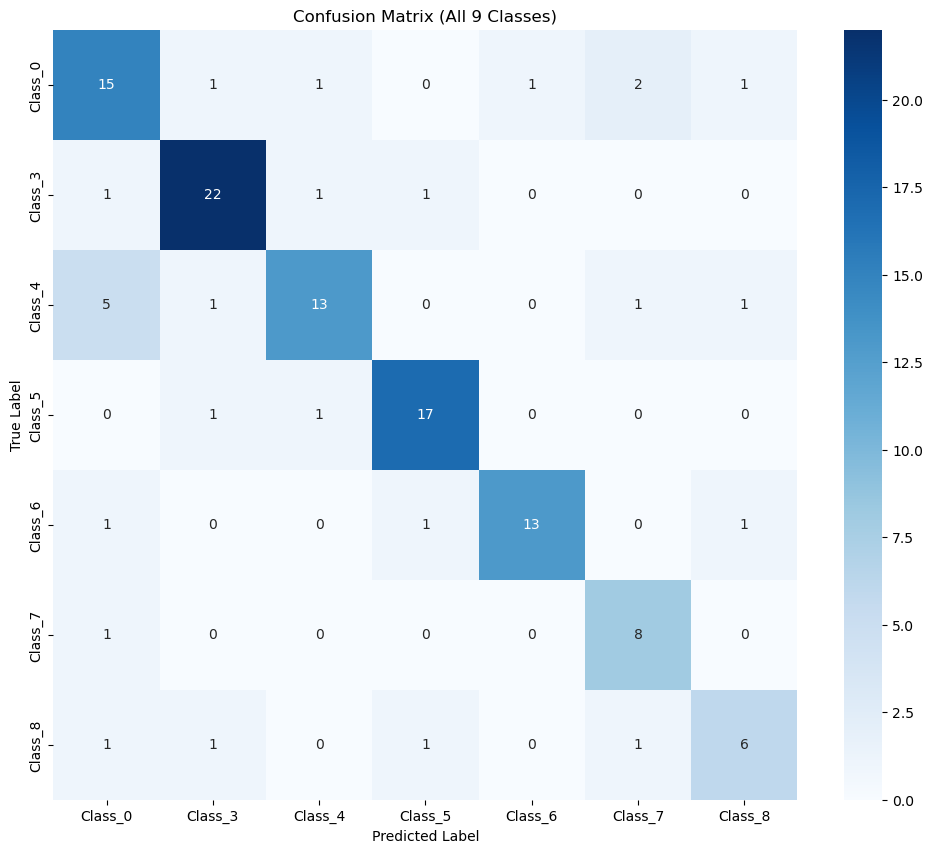

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_complete_class_performance(model, loader, all_classes=[0, 3, 4, 5, 6, 7, 8]):
    """Analyze performance for ALL classes the model outputs"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for raw_batch, psd_batch, labels in loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device)
            
            outputs = model(raw_batch, psd_batch)
            _, preds = outputs.max(1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Use ALL classes that the model can predict (9 classes)
    # not just the ones that appear in this particular batch
    class_names = [f'Class_{i}' for i in all_classes]
    
    print("=== COMPLETE CLASS PERFORMANCE (9 classes) ===")
    print(classification_report(all_labels, all_preds, 
                               labels=all_classes,  # Force include all 9 classes
                               target_names=class_names, 
                               digits=4,
                               zero_division=0))  # Handle classes with no samples
    
    # Confusion matrix for all classes
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(all_labels, all_preds, labels=all_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (All 9 Classes)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # return all_preds, all_labels

# Run the complete analysis with ALL 9 classes
all_classes = [0, 3, 4, 5, 6, 7, 8]  # Your actual class labels
analyze_complete_class_performance(model, test_loader, all_classes)

In [16]:
def analyze_class_8_errors(model, loader):
    """Targeted analysis for Class 8"""
    model.eval()
    errors = []
    
    with torch.no_grad():
        for raw_batch, psd_batch, labels in loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device)
            
            outputs = model(raw_batch, psd_batch)
            _, preds = outputs.max(1)
            
            labels_cpu = labels.cpu().numpy()
            preds_cpu = preds.cpu().numpy()
            
            for i in range(len(labels_cpu)):
                if labels_cpu[i] == 8 and preds_cpu[i] != 8:
                    errors.append({
                        'true': 8,
                        'predicted': preds_cpu[i],
                        'confidence': F.softmax(outputs[i], dim=0)[preds[i]].item()
                    })
    
    print(f"Class 8 errors: {len(errors)}")
    
    from collections import Counter
    confusion_counts = Counter([error['predicted'] for error in errors])
    print("Class 8 is most often confused with:")
    for pred_class, count in confusion_counts.most_common():
        print(f"  Class {pred_class}: {count} times")
    
    return errors

class_8_errors = analyze_class_8_errors(model, test_loader)

Class 8 errors: 4
Class 8 is most often confused with:
  Class 7: 1 times
  Class 0: 1 times
  Class 5: 1 times
  Class 3: 1 times


In [ ]:
# Seeds
torch.manual_seed(42); np.random.seed(42); random.seed(42)
# Device
device = torch.device("mps" if torch.backends.mps.is_available() else 
                      "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------- Data ----------------
with open(f"{DATAFILES_DIR}/compressed_label_map.json", 'r') as f:
    label_map = json.load(f)

train_dataset = WideNormalizationIMUSonarFromJSON(
    f"{DATAFILES_DIR}/train_split.json",
    label_map=label_map,
    target_length=600,
    noise_level=0.001,
    # window_length=128,
    # stride=32,          # lots of windows
    add_noise=True      # enable training-time augmentation
)
test_dataset = WideNormalizationIMUSonarFromJSON(
    f"{DATAFILES_DIR}/test_split.json",
    label_map=label_map,
    target_length=600,
    # window_length=128,
    # stride=32,   # lots of windows
    add_noise=False
)

# Compute global stats on TRAIN ONLY, then share with TEST
train_dataset.compute_global_stats()
test_dataset.global_mean = train_dataset.global_mean.clone()
test_dataset.global_std  = train_dataset.global_std.clone()

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=0, drop_last=False)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=0, drop_last=False)

# ---------------- Model ----------------
sample_raw, sample_psd, _ = train_dataset[0]
num_channels = sample_raw.shape[0]
psd_bins = sample_psd.shape[1]
num_classes = len(label_map)

In [60]:
import torch
import torch.nn as nn
from torch.optim import Adam
from sklearn.metrics import accuracy_score

def train_and_evaluate(model, optimizer, train_loader, test_loader, epochs=50):
    """
    Train and evaluate the model
    """
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    # All Evaluation predictions and targets
    all_accuracy = []
    best_acc = 0.0
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        for raw_batch, psd_batch, labels in train_loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels    = labels.to(device).long()
    
            optimizer.zero_grad()
            outputs = model(raw_batch, psd_batch)
            loss = criterion(outputs, labels)
            loss.backward()
            # gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        # Initialize local pred and labels
        preds = []
        targets = []
        
        with torch.no_grad():
            model.eval()
            for raw_batch, psd_batch, labels in test_loader:
                raw_batch = raw_batch.to(device)
                psd_batch = psd_batch.to(device)
                labels    = labels.to(device).long()
                
                outputs = model(raw_batch, psd_batch)
                pred = outputs.argmax(dim=1)
                
                preds.extend(pred.cpu().numpy())
                targets.extend(labels.cpu().numpy())

        accuracy = accuracy_score(targets, preds)
        all_accuracy.append(accuracy)
        # Early stopping check
        if accuracy > best_acc:
            best_acc = accuracy
            best_weights = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 5:  # 5 epochs no improvement
                break

    return best_acc

# Your grid search code (you'll need to define train_loader and val_loader)
learning_rates = [1e-4, 3e-4, 1e-3, 3e-3]
dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5]
weight_decays = [0, 1e-5, 1e-4, 1e-3]

best_acc = 0
best_params = {}
accuracies = []
results = []

print('Starting experiments...')
for instance in range(101):
    print(f'Running experiment {instance}/100')
    for lr in learning_rates:
        for dropout in dropout_rates:
            for wd in weight_decays:
                model = SimpleIMUSonarNet(num_channels=8, num_classes=num_classes, psd_bins=psd_bins, dropout=dropout)
                optimizer = Adam(model.parameters(), lr=lr, weight_decay=wd)
                # Train quickly for 10 epochs to compare
                acc = train_and_evaluate(model, optimizer, train_loader, test_loader, epochs=50)
                accuracies.append(acc)
                #print(f'Processed experiment with learning rate: {lr}, dropout: {dropout}, and weight decay: {wd}. Experiment Accuracy: {acc:.4f}')
                if acc > best_acc:
                    best_acc = acc
                    best_params = {'lr': lr, 'dropout': dropout, 'weight_decay': wd}
    # Capture instance info
    results.append({
        'mean': np.mean(accuracies),
        'std': np.std(accuracies),
        'max': np.max(accuracies),
        'min': np.min(accuracies),
        'params': best_params,
        'accuracy': best_acc
    })
best = {}
for instance in results:
    if best is None: best = instance
    elif instance['accuracy'] > best['accuracy']: best = instance

print(f"For 100 experiments - Best params: {instance['params']}, Accuracy: {instance['accuracy']:.3f}")
# print(f"Best params: {best_params}, Accuracy: {best_acc:.3f}")
# print(f"{results['params']}: {results}")

Starting experiments...
Running experiment 0/100


KeyboardInterrupt: 

In [30]:
# Current best configuration
best_lr = 0.0003  # From your latest test
best_dropout = 0.2  # From grid search
best_wd = 0.001     # From grid search

In [31]:
# Test around your best LR
fine_tune_lrs = [0.0003, 0.00032, 0.00035, 0.00038, 0.0004]
for lr in fine_tune_lrs:
    # Quick test with your best dropout and weight decay
    model = SimpleIMUSonarNet(num_channels=8, num_classes=num_classes, psd_bins=psd_bins, dropout=best_dropout)
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=best_wd)
    acc = train_and_evaluate(model, optimizer, train_loader, test_loader, epochs=50)
    print(f"LR {lr}: {acc:.3f}")

Using device: mps
LR 0.0003: 0.752
LR 0.00032: 0.785
LR 0.00035: 0.769
LR 0.00038: 0.769
LR 0.0004: 0.719


# Additional Feature extraction
The dataset will extract additional features to assist with training correlation

In [196]:
import json
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from scipy.interpolate import interp1d
from scipy.signal import welch

class WideNormFeatureExtractIMUSonarFromJSON(WideNormalizationIMUSonarFromJSON):
    """Dataset for IMU + Ultrasonic with raw + PSD output and feature extraction support"""

    def _extract_features(self, data):
        """Extract meaningful features from normalized sensor data with robustness"""
        if torch.is_tensor(data):
            data = data.numpy()
        
        C, T = data.shape
        features = []
        
        # 1. Basic statistical features per channel (with robustness)
        for ch in range(C):
            channel_data = data[ch]
            
            # Basic stats that are always safe
            channel_features = [
                np.mean(channel_data),      # DC offset
                np.std(channel_data),       # Variability
                np.max(channel_data),       # Peak amplitude
                np.min(channel_data),       # Minimum amplitude
                np.ptp(channel_data),       # Peak-to-peak
            ]
            
            # Robust skewness and kurtosis calculation
            if np.std(channel_data) > 1e-6:  # Only calculate if there's variation
                try:
                    channel_features.append(skew(channel_data))
                except:
                    channel_features.append(0.0)  # Fallback for skewness
                
                try:
                    channel_features.append(kurtosis(channel_data))
                except:
                    channel_features.append(0.0)  # Fallback for kurtosis
            else:
                channel_features.extend([0.0, 0.0])  # No variation = symmetric, normal
                
            features.extend(channel_features)
        
        # 2. Cross-sensor correlation features (with robustness)
        # Accelerometer correlations
        if np.any(np.std(data[0:3], axis=1) > 1e-6):  # Check if any accel channel has variation
            try:
                accel_corr = np.corrcoef(data[0:3])
                features.extend([accel_corr[0,1], accel_corr[0,2], accel_corr[1,2]])
            except:
                features.extend([0.0, 0.0, 0.0])
        else:
            features.extend([0.0, 0.0, 0.0])
        
        # Gyroscope correlations
        if np.any(np.std(data[3:6], axis=1) > 1e-6):
            try:
                gyro_corr = np.corrcoef(data[3:6])
                features.extend([gyro_corr[0,1], gyro_corr[0,2], gyro_corr[1,2]])
            except:
                features.extend([0.0, 0.0, 0.0])
        else:
            features.extend([0.0, 0.0, 0.0])
        
        # 3. Time-domain features for movement characterization
        for ch in range(6):  # For IMU channels only
            channel_data = data[ch]
            if len(channel_data) > 1 and np.std(channel_data) > 1e-6:
                derivatives = np.diff(channel_data)
                features.extend([
                    np.mean(np.abs(derivatives)),    # Average movement intensity
                    np.std(derivatives),             # Movement variability
                    (np.abs(derivatives) > 0.1).mean(),  # Proportion of significant movements
                ])
            else:
                features.extend([0.0, 0.0, 0.0])
        
        # 4. Sonar-specific features
        for ch in range(6, 8):  # For sonar channels
            channel_data = data[ch]
            if len(channel_data) > 0:
                median_val = np.median(channel_data)
                features.extend([
                    median_val,         # Typical distance
                    (channel_data > median_val + 0.5).mean(),  # Far events
                    (channel_data < median_val - 0.5).mean(),  # Near events
                ])
            else:
                features.extend([0.0, 0.0, 0.0])
        
        # 5. Cross-modal features (IMU + Sonar relationships)
        try:
            if data.shape[1] > 1:  # Need at least 2 time points for derivatives
                avg_movement = np.mean(np.abs(np.diff(data[0:6], axis=1)), axis=0)
                sonar_change = np.abs(np.diff(data[6:8], axis=1)).mean(axis=0)
                
                min_len = min(len(avg_movement), len(sonar_change))
                if min_len > 1:
                    movement_sonar_corr = np.corrcoef(avg_movement[:min_len], 
                                                     sonar_change[:min_len])[0,1]
                    features.append(movement_sonar_corr if not np.isnan(movement_sonar_corr) else 0.0)
                else:
                    features.append(0.0)
            else:
                features.append(0.0)
        except:
            features.append(0.0)
        
        return torch.tensor(features, dtype=torch.float32)

    def __getitem__(self, idx):
        # sample_idx, start, end = self.window_index[idx]
        item = self.samples[idx]
        df = pd.read_csv(item['path'])
    
        # Resample to get raw data (C, T)
        # full_data = self._resample_to_uniform(df)
        # data = full_data[:, start:end]  # Slice the window
        data = self._resample_to_uniform(df)
        
        # --- NEW: Add feature extraction here ---
        features = self._extract_features(data)
        
        # Estimate sample frequency for PSD
        total_time_sec = (df['Timestamp(ms)'].iloc[-1] - df['Timestamp(ms)'].iloc[0]) / 1000.0
        fs_est = self.target_length / total_time_sec if total_time_sec > 0 else 50.0
    
        # Compute PSD - FIX: data is already numpy, no need for .numpy()
        psd = self.compute_psd(data, fs=fs_est)  # REMOVE .numpy() here!
    
        # Return raw data, PSD, AND the new features
        return (torch.tensor(data, dtype=torch.float32), 
                torch.tensor(psd, dtype=torch.float32), 
                features, 
                torch.tensor(item['label'], dtype=torch.long))

In [197]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EnhancedIMUSonarNet(nn.Module):
    """
    Enhanced model with three input branches: raw time series, PSD, and engineered features
    """
    def __init__(self, num_channels=8, num_classes=7, psd_bins=64, num_engineered_features=50, dropout=0.2):
        super().__init__()
        
        # --- Time domain branch ---
        self.time_conv = nn.Sequential(
            nn.Conv1d(num_channels, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout/3),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout/3),
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool1d(1)
        )
        
        # --- PSD branch ---
        self.psd_fc = nn.Sequential(
            nn.Linear(num_channels * psd_bins, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout/2)
        )
        
        # --- Engineered Features branch ---
        self.feature_mlp = nn.Sequential(
            nn.Linear(num_engineered_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout/2),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout/3)
        )
        
        # --- Fusion and classification ---
        # 256 (time) + 128 (PSD) + 64 (features) = 448 total features
        self.classifier = nn.Sequential(
            nn.Linear(256 + 128 + 64, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout/2),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout/2),
            nn.Linear(128, num_classes)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)
    
    def forward(self, raw_x, psd_x, features_x):
        # Time domain processing
        time_features = self.time_conv(raw_x).squeeze(-1)
        
        # PSD processing
        psd_flat = psd_x.view(psd_x.size(0), -1)
        psd_features = self.psd_fc(psd_flat)
        
        # Engineered features processing
        feature_features = self.feature_mlp(features_x)
        
        # Concatenate all three branches and classify
        combined = torch.cat([time_features, psd_features, feature_features], dim=1)
        logits = self.classifier(combined)
        
        return logits

In [200]:
import os
import torch
import numpy as np
import random
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from time import time
import torch.nn as nn
import json

# Seeds
torch.manual_seed(42); np.random.seed(42); random.seed(42)

# Device
device = torch.device("mps" if torch.backends.mps.is_available() else 
                      "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------- Data ----------------
with open(f"{DATAFILES_DIR}/compressed_label_map.json", 'r') as f:
    label_map = json.load(f)

train_dataset = WideNormFeatureExtractIMUSonarFromJSON(
    f"{DATAFILES_DIR}/train_split.json",
    label_map=label_map,
    target_length=600,
    add_noise=False  # No augmentation since we're using engineered features
)
test_dataset = WideNormFeatureExtractIMUSonarFromJSON(
    f"{DATAFILES_DIR}/test_split.json", 
    label_map=label_map,
    target_length=600,
    add_noise=False
)

# Compute global stats on TRAIN ONLY, then share with TEST
train_dataset.compute_global_stats()
test_dataset.global_mean = train_dataset.global_mean.clone()
test_dataset.global_std  = train_dataset.global_std.clone()

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=0, drop_last=False)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=0, drop_last=False)

# ---------------- Model ----------------
# Get sample to determine feature dimensions
sample_raw, sample_psd, sample_features, _ = train_dataset[0]
num_channels = sample_raw.shape[0]
psd_bins = sample_psd.shape[1]
num_engineered_features = sample_features.shape[0]
num_classes = len(label_map)

print(f"Input dimensions: {num_channels} channels, {psd_bins} PSD bins, {num_engineered_features} engineered features")
print(f"Number of classes: {num_classes}")

model = EnhancedIMUSonarNet(
    num_channels=num_channels,
    num_classes=num_classes,
    psd_bins=psd_bins,
    num_engineered_features=num_engineered_features,
    dropout=0.3  # Slightly higher dropout for the larger model
).to(device)

# ---------------- Train loop ----------------
epochs = 50

# # Compute class weights on training data
# train_dataset.compute_class_stats()
# # Use the computed weights in your loss function
# criterion = nn.CrossEntropyLoss(
#     weight=train_dataset.class_weights.to(device), 
#     label_smoothing=0.05
# )
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # Reduced weight decay
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

# Early stopping
best_val_acc = 0.0
patience = 5
no_improve_epochs = 0
best_state = None

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    epoch_start = time()
    
    for raw_batch, psd_batch, features_batch, labels in train_loader:
        raw_batch = raw_batch.to(device)
        psd_batch = psd_batch.to(device)
        features_batch = features_batch.to(device)
        labels = labels.to(device).long()

        optimizer.zero_grad()
        outputs = model(raw_batch, psd_batch, features_batch)
        loss = criterion(outputs, labels)
        loss.backward()
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total   += labels.size(0)
    
    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for raw_batch, psd_batch, features_batch, labels in test_loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            features_batch = features_batch.to(device)
            labels = labels.to(device).long()
            
            outputs = model(raw_batch, psd_batch, features_batch)
            val_loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(labels).sum().item()
            val_total   += labels.size(0)
    
    # Metrics
    train_loss = running_loss / len(train_loader)
    train_acc  = correct / total
    val_loss   = val_loss / len(test_loader)
    val_acc    = val_correct / val_total
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Scheduler step
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch + 1}/{epochs} - {time() - epoch_start:.1f}s | " \
            f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | " \
            f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    
    # # Early stopping
    # if val_acc > best_val_acc:
    #     best_val_acc = val_acc
    #     no_improve_epochs = 0
    #     best_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
    # else:
    #     no_improve_epochs += 1
    #     if no_improve_epochs >= patience:
    #         print(f"⏹ Early stopping at epoch {epoch+1} (best val acc {best_val_acc:.4f})")
    #         break

# # Restore best model
# if best_state is not None:
#     model.load_state_dict(best_state)

# ---------------- Final evaluation ----------------
def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for raw_batch, psd_batch, features_batch, labels in loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            features_batch = features_batch.to(device)
            labels = labels.to(device).long()
            
            outputs = model(raw_batch, psd_batch, features_batch)
            total_loss += criterion(outputs, labels).item() * raw_batch.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total   += labels.size(0)
    return total_loss / total, correct / total

train_loss, train_acc = evaluate(model, train_loader)
test_loss,  test_acc  = evaluate(model, test_loader)

print('Final Results:')
print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')
print(f'Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}')

Using device: mps
Input dimensions: 8 channels, 65 PSD bins, 87 engineered features
Number of classes: 9
Epoch 1/50 - 3.2s | Train Loss: 2.4536 Acc: 0.2549 | Val Loss: 1.6564 Acc: 0.5124
Epoch 2/50 - 3.0s | Train Loss: 1.7741 Acc: 0.4706 | Val Loss: 1.3013 Acc: 0.6033
Epoch 3/50 - 3.3s | Train Loss: 1.4073 Acc: 0.5809 | Val Loss: 1.2045 Acc: 0.6860
Epoch 4/50 - 3.3s | Train Loss: 1.2564 Acc: 0.6176 | Val Loss: 1.1816 Acc: 0.6694
Epoch 5/50 - 3.1s | Train Loss: 1.2130 Acc: 0.6348 | Val Loss: 1.1793 Acc: 0.6446
Epoch 6/50 - 3.3s | Train Loss: 1.0707 Acc: 0.6961 | Val Loss: 1.2015 Acc: 0.6777
Epoch 7/50 - 3.4s | Train Loss: 1.0672 Acc: 0.6912 | Val Loss: 1.1249 Acc: 0.7025
Epoch 8/50 - 3.3s | Train Loss: 0.9775 Acc: 0.7426 | Val Loss: 1.1138 Acc: 0.7355
Epoch 9/50 - 3.3s | Train Loss: 0.8936 Acc: 0.7647 | Val Loss: 0.9799 Acc: 0.7603
Epoch 10/50 - 3.1s | Train Loss: 0.8128 Acc: 0.7917 | Val Loss: 1.1193 Acc: 0.7107
Epoch 11/50 - 3.1s | Train Loss: 0.8354 Acc: 0.7868 | Val Loss: 0.9964 Acc

# Weighted Class Dataset Training
This will create weights for unbalanced classes (labels)

In [208]:
import json
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from scipy.interpolate import interp1d
from scipy.signal import welch

class WideNormWeightedClassesIMUSonarFromJSON(WideNormalizationIMUSonarFromJSON):
    """Dataset for IMU + Ultrasonic with raw + PSD output and class weighting support"""

    def __init__(self, json_file, label_map=None, transform=None, target_length=600, debug=False, add_noise=False, noise_level=0.01):
        with open(json_file, 'r') as f:
            self.samples = json.load(f)

        self.transform = transform
        self.label_map = {v: k for k, v in label_map.items()} if label_map else {}
        self.target_length = target_length
        self.debug = debug
        self.add_noise = add_noise
        self.noise_level = noise_level
        self.cols = IMUSonarFromJSON.cols

        # Initialize class statistics
        self.class_counts = None
        self.class_weights = None

    def compute_class_stats(self):
        """Compute class distribution and weights for imbalanced data, including empty classes"""
        # Define ALL 9 classes in your labeling system (including empty ones)
        all_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8]  # Your complete 9-class system
        num_classes = len(all_classes)
        
        # Count samples per class (empty classes will have 0)
        class_counts = torch.zeros(num_classes)
        for item in self.samples:
            label = item['label']
            if label in all_classes:
                class_index = all_classes.index(label)
                class_counts[class_index] += 1
            else:
                print(f"Warning: Label {label} not in expected class system")
        
        self.class_counts = class_counts
        
        # Compute class weights - handle empty classes carefully
        # For empty classes, use a reasonable default weight (e.g., average weight)
        non_zero_counts = class_counts[class_counts > 0]
        if len(non_zero_counts) > 0:
            default_weight = 1.0 / (non_zero_counts.float().mean() + 1e-6)
        else:
            default_weight = 1.0
        
        self.class_weights = torch.where(
            class_counts > 0,
            1.0 / (class_counts.float() + 1e-6),  # Inverse frequency for non-empty classes
            torch.full_like(class_counts.float(), default_weight)  # Default for empty classes
        )
        
        # Normalize weights
        self.class_weights = self.class_weights / self.class_weights.sum()
        
        print("Class distribution (9-class system):")
        for i, class_label in enumerate(all_classes):
            status = "EMPTY" if class_counts[i] == 0 else "HAS SAMPLES"
            print(f"Class {class_label}: {class_counts[i]} samples, weight: {self.class_weights[i]:.6f} ({status})")
        
        return self.class_weights

    def __getitem__(self, idx):
        """Return (raw_tensor, psd_tensor, label)"""
        item = self.samples[idx]
        df = pd.read_csv(item['path'])

        # Resample to uniform shape (C, T)
        data = self._resample_to_uniform(df)

        # Estimate sample frequency for PSD
        total_time_sec = (df['Timestamp(ms)'].iloc[-1] - df['Timestamp(ms)'].iloc[0]) / 1000.0
        fs_est = self.target_length / total_time_sec if total_time_sec > 0 else 50.0

        # Compute PSD (C, F)
        psd = self.compute_psd(data, fs=fs_est)

        # Convert to tensors
        if isinstance(data, np.ndarray): 
            raw_tensor = torch.tensor(data, dtype=torch.float32)
        else: 
            raw_tensor = data
        psd_tensor = torch.tensor(psd, dtype=torch.float32)

        label = self.label_map[item['label']] if self.label_map else item['label']
        label_tensor = torch.tensor(item['label'], dtype=torch.long)

        return raw_tensor, psd_tensor, label_tensor

In [211]:
import os
import torch
import numpy as np
import random
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from time import time
import torch.nn as nn
import json

# Seeds
torch.manual_seed(42); np.random.seed(42); random.seed(42)

# Device
device = torch.device("mps" if torch.backends.mps.is_available() else 
                      "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------- Data ----------------
with open(f"{DATAFILES_DIR}/compressed_label_map.json", 'r') as f:
    label_map = json.load(f)

train_dataset = WideNormWeightedClassesIMUSonarFromJSON(
    f"{DATAFILES_DIR}/train_split.json",
    label_map=label_map,
    target_length=600,
    noise_level=0.001,
    add_noise=True  # No augmentation since we're using engineered features
)
test_dataset = WideNormWeightedClassesIMUSonarFromJSON(
    f"{DATAFILES_DIR}/test_split.json", 
    label_map=label_map,
    target_length=600,
    add_noise=False
)

# Compute global stats on TRAIN ONLY, then share with TEST
train_dataset.compute_global_stats()
test_dataset.global_mean = train_dataset.global_mean.clone()
test_dataset.global_std  = train_dataset.global_std.clone()

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=0, drop_last=False)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=0, drop_last=False)

# ---------------- Model ----------------
# Get sample to determine feature dimensions
sample_raw, sample_psd, _ = train_dataset[0]
num_channels = sample_raw.shape[0]
psd_bins = sample_psd.shape[1]
num_classes = len(label_map)

print(f"Input dimensions: {num_channels} channels, {psd_bins} PSD bins, {num_engineered_features} engineered features")
print(f"Number of classes: {num_classes}")

model = SimpleIMUSonarNet(
    num_channels=num_channels,
    num_classes=num_classes,
    psd_bins=psd_bins,
    dropout=0.3  # Slightly higher dropout for the larger model
).to(device)

# ---------------- Train loop ----------------
epochs = 50

# Compute class weights on training data
train_dataset.compute_class_stats()
# Use the computed weights in your loss function
criterion = nn.CrossEntropyLoss(
    weight=train_dataset.class_weights.to(device), 
    label_smoothing=0.05
)
#criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # Reduced weight decay
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

# Early stopping
best_val_acc = 0.0
patience = 5
no_improve_epochs = 0
best_state = None

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    epoch_start = time()
    
    for raw_batch, psd_batch, labels in train_loader:
        raw_batch = raw_batch.to(device)
        psd_batch = psd_batch.to(device)
        labels = labels.to(device).long()

        optimizer.zero_grad()
        outputs = model(raw_batch, psd_batch)
        loss = criterion(outputs, labels)
        loss.backward()
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total   += labels.size(0)
    
    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for raw_batch, psd_batch, labels in test_loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device).long()
            
            outputs = model(raw_batch, psd_batch)
            val_loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(labels).sum().item()
            val_total   += labels.size(0)
    
    # Metrics
    train_loss = running_loss / len(train_loader)
    train_acc  = correct / total
    val_loss   = val_loss / len(test_loader)
    val_acc    = val_correct / val_total
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Scheduler step
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch + 1}/{epochs} - {time() - epoch_start:.1f}s | " \
            f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | " \
            f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    
    # # Early stopping
    # if val_acc > best_val_acc:
    #     best_val_acc = val_acc
    #     no_improve_epochs = 0
    #     best_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
    # else:
    #     no_improve_epochs += 1
    #     if no_improve_epochs >= patience:
    #         print(f"⏹ Early stopping at epoch {epoch+1} (best val acc {best_val_acc:.4f})")
    #         break

# # Restore best model
# if best_state is not None:
#     model.load_state_dict(best_state)

# ---------------- Final evaluation ----------------
def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for raw_batch, psd_batch, labels in loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device).long()
            
            outputs = model(raw_batch, psd_batch)
            total_loss += criterion(outputs, labels).item() * raw_batch.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total   += labels.size(0)
    return total_loss / total, correct / total

train_loss, train_acc = evaluate(model, train_loader)
test_loss,  test_acc  = evaluate(model, test_loader)

print('Final Results:')
print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')
print(f'Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}')

Using device: mps
Input dimensions: 8 channels, 65 PSD bins, 87 engineered features
Number of classes: 9
Class distribution (9-class system):
Class 0: 81.0 samples, weight: 0.072852 (HAS SAMPLES)
Class 1: 0.0 samples, weight: 0.101243 (EMPTY)
Class 2: 0.0 samples, weight: 0.101243 (EMPTY)
Class 3: 80.0 samples, weight: 0.073763 (HAS SAMPLES)
Class 4: 64.0 samples, weight: 0.092204 (HAS SAMPLES)
Class 5: 64.0 samples, weight: 0.092204 (HAS SAMPLES)
Class 6: 52.0 samples, weight: 0.113482 (HAS SAMPLES)
Class 7: 32.0 samples, weight: 0.184408 (HAS SAMPLES)
Class 8: 35.0 samples, weight: 0.168601 (HAS SAMPLES)
Epoch 1/50 - 1.5s | Train Loss: 2.4807 Acc: 0.2304 | Val Loss: 1.7758 Acc: 0.3719
Epoch 2/50 - 1.4s | Train Loss: 1.7939 Acc: 0.4608 | Val Loss: 1.4196 Acc: 0.5289
Epoch 3/50 - 1.4s | Train Loss: 1.4504 Acc: 0.5466 | Val Loss: 1.2920 Acc: 0.6364
Epoch 4/50 - 1.4s | Train Loss: 1.2977 Acc: 0.6275 | Val Loss: 1.2144 Acc: 0.6529
Epoch 5/50 - 1.4s | Train Loss: 1.2394 Acc: 0.6422 | Val L

In [224]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_class_performance(model, loader, class_names):
    """Analyze performance per class to see where the issues are"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for raw_batch, psd_batch, labels in loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device)
            
            outputs = model(raw_batch, psd_batch)
            _, preds = outputs.max(1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Classification report
    print("=== PER-CLASS PERFORMANCE ===")
    print(len(np.unique(all_labels)))
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))
    
    # Confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    #return all_preds, all_labels

# Run the analysis
class_names = [f'Class_{i}' for i in range(9)]  # Only your 7 actual classes
analyze_class_performance(model, test_loader, class_names)

=== PER-CLASS PERFORMANCE ===
7


ValueError: Number of classes, 7, does not match size of target_names, 9. Try specifying the labels parameter

In [217]:
# Only analyze classes that actually have data
def realistic_class_analysis(model, loader):
    model.eval()
    # Only track classes that exist: 0, 3, 4, 5, 6
    class_stats = {0: {'correct': 0, 'total': 0},
                   3: {'correct': 0, 'total': 0}, 
                   4: {'correct': 0, 'total': 0},
                   5: {'correct': 0, 'total': 0},
                   6: {'correct': 0, 'total': 0}}
    
    with torch.no_grad():
        for raw_batch, psd_batch, labels in loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device)
            
            outputs = model(raw_batch, psd_batch)
            _, preds = outputs.max(1)
            
            labels_cpu = labels.cpu().numpy()
            preds_cpu = preds.cpu().numpy()
            
            for i in range(len(labels_cpu)):
                label = labels_cpu[i]
                if label in class_stats:
                    class_stats[label]['total'] += 1
                    if preds_cpu[i] == label:
                        class_stats[label]['correct'] += 1
    
    print("Realistic class analysis:")
    for class_label, stats in class_stats.items():
        if stats['total'] > 0:
            accuracy = stats['correct'] / stats['total']
            print(f"Class {class_label}: {stats['correct']}/{stats['total']} = {accuracy:.3f}")
    
    return class_stats

realistic_class_analysis(model, test_loader)

Realistic class analysis:
Class 0: 14/21 = 0.667
Class 3: 21/25 = 0.840
Class 4: 10/21 = 0.476
Class 5: 18/19 = 0.947
Class 6: 14/16 = 0.875


{0: {'correct': 14, 'total': 21},
 3: {'correct': 21, 'total': 25},
 4: {'correct': 10, 'total': 21},
 5: {'correct': 18, 'total': 19},
 6: {'correct': 14, 'total': 16}}

In [216]:
def manual_class_analysis(model, loader):
    model.eval()
    class_correct = [0] * 7
    class_total = [0] * 7
    
    with torch.no_grad():
        for raw_batch, psd_batch, labels in loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device)
            
            outputs = model(raw_batch, psd_batch)
            _, preds = outputs.max(1)
            
            # Convert to CPU
            labels_cpu = labels.cpu().numpy()
            preds_cpu = preds.cpu().numpy()
            
            for i in range(len(labels_cpu)):
                label = labels_cpu[i]
                if label < 7:  # Only your 7 actual classes
                    class_total[label] += 1
                    if preds_cpu[i] == label:
                        class_correct[label] += 1
    
    print("Manual class analysis:")
    for i in range(7):
        accuracy = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f"Class {i}: {class_correct[i]}/{class_total[i]} = {accuracy:.3f}")
    
    return class_correct, class_total

manual_class_analysis(model, test_loader)

Manual class analysis:
Class 0: 14/21 = 0.667
Class 1: 0/0 = 0.000
Class 2: 0/0 = 0.000
Class 3: 21/25 = 0.840
Class 4: 10/21 = 0.476
Class 5: 18/19 = 0.947
Class 6: 14/16 = 0.875


([14, 0, 0, 21, 10, 18, 14], [21, 0, 0, 25, 21, 19, 16])

In [218]:
# Check what's REALLY in your test dataset
print("=== TEST DATASET ANALYSIS ===")
test_labels = [item['label'] for item in test_dataset.samples]
unique_test_labels = sorted(set(test_labels))
print(f"Unique labels in test data: {unique_test_labels}")

label_counts = {}
for label in test_labels:
    label_counts[label] = label_counts.get(label, 0) + 1

print("Label distribution in test set:")
for label, count in sorted(label_counts.items()):
    print(f"Label {label}: {count} samples")

    # Check what's REALLY in your test dataset
print("=== TRAIN DATASET ANALYSIS ===")
train_labels = [item['label'] for item in train_dataset.samples]
unique_train_labels = sorted(set(train_labels))
print(f"Unique labels in train data: {unique_train_labels}")

label_counts = {}
for label in train_labels:
    label_counts[label] = label_counts.get(label, 0) + 1

print("Label distribution in test set:")
for label, count in sorted(label_counts.items()):
    print(f"Label {label}: {count} samples")

=== TEST DATASET ANALYSIS ===
Unique labels in test data: [0, 3, 4, 5, 6, 7, 8]
Label distribution in test set:
Label 0: 21 samples
Label 3: 25 samples
Label 4: 21 samples
Label 5: 19 samples
Label 6: 16 samples
Label 7: 9 samples
Label 8: 10 samples
=== TRAIN DATASET ANALYSIS ===
Unique labels in train data: [0, 3, 4, 5, 6, 7, 8]
Label distribution in test set:
Label 0: 81 samples
Label 3: 80 samples
Label 4: 64 samples
Label 5: 64 samples
Label 6: 52 samples
Label 7: 32 samples
Label 8: 35 samples


In [219]:
def complete_class_analysis(model, loader):
    """Analyze ALL classes including 7 and 8"""
    model.eval()
    # Track all 7 classes that exist in your data
    class_stats = {0: {'correct': 0, 'total': 0},
                   3: {'correct': 0, 'total': 0},
                   4: {'correct': 0, 'total': 0},
                   5: {'correct': 0, 'total': 0},
                   6: {'correct': 0, 'total': 0},
                   7: {'correct': 0, 'total': 0},
                   8: {'correct': 0, 'total': 0}}
    
    with torch.no_grad():
        for raw_batch, psd_batch, labels in loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device)
            
            outputs = model(raw_batch, psd_batch)
            _, preds = outputs.max(1)
            
            labels_cpu = labels.cpu().numpy()
            preds_cpu = preds.cpu().numpy()
            
            for i in range(len(labels_cpu)):
                label = labels_cpu[i]
                if label in class_stats:
                    class_stats[label]['total'] += 1
                    if preds_cpu[i] == label:
                        class_stats[label]['correct'] += 1
    
    print("COMPLETE class analysis:")
    for class_label in sorted(class_stats.keys()):
        stats = class_stats[class_label]
        if stats['total'] > 0:
            accuracy = stats['correct'] / stats['total']
            print(f"Class {class_label}: {stats['correct']}/{stats['total']} = {accuracy:.3f}")
        else:
            print(f"Class {class_label}: 0/0 = N/A")
    
    return class_stats

# Run the complete analysis
complete_stats = complete_class_analysis(model, test_loader)

COMPLETE class analysis:
Class 0: 14/21 = 0.667
Class 3: 21/25 = 0.840
Class 4: 10/21 = 0.476
Class 5: 18/19 = 0.947
Class 6: 14/16 = 0.875
Class 7: 8/9 = 0.889
Class 8: 7/10 = 0.700


In [220]:
def analyze_problem_classes(model, loader):
    """Analyze Class 4 and Class 0 errors in detail"""
    model.eval()
    errors = []
    
    with torch.no_grad():
        for raw_batch, psd_batch, labels in loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device)
            
            outputs = model(raw_batch, psd_batch)
            _, preds = outputs.max(1)
            
            labels_cpu = labels.cpu().numpy()
            preds_cpu = preds.cpu().numpy()
            
            for i in range(len(labels_cpu)):
                label = labels_cpu[i]
                if label in [0, 4] and preds_cpu[i] != label:  # Only problem classes
                    errors.append({
                        'true': label,
                        'predicted': preds_cpu[i],
                        'confidence': F.softmax(outputs[i], dim=0)[preds[i]].item()
                    })
    
    # Analyze confusion patterns
    from collections import Counter
    print("Class 4 confusion:")
    class_4_errors = [e for e in errors if e['true'] == 4]
    confusion_4 = Counter([e['predicted'] for e in class_4_errors])
    for pred, count in confusion_4.most_common():
        print(f"  Class 4 → Class {pred}: {count} times")
    
    print("Class 0 confusion:")  
    class_0_errors = [e for e in errors if e['true'] == 0]
    confusion_0 = Counter([e['predicted'] for e in class_0_errors])
    for pred, count in confusion_0.most_common():
        print(f"  Class 0 → Class {pred}: {count} times")
    
    return errors

problem_errors = analyze_problem_classes(model, test_loader)

Class 4 confusion:
  Class 4 → Class 8: 3 times
  Class 4 → Class 3: 3 times
  Class 4 → Class 0: 2 times
  Class 4 → Class 7: 2 times
  Class 4 → Class 5: 1 times
Class 0 confusion:
  Class 0 → Class 4: 2 times
  Class 0 → Class 8: 2 times
  Class 0 → Class 7: 2 times
  Class 0 → Class 3: 1 times


=== COMPLETE CLASS PERFORMANCE (9 classes) ===
              precision    recall  f1-score   support

     Class_0     0.8235    0.6667    0.7368        21
     Class_3     0.7778    0.8400    0.8077        25
     Class_4     0.7143    0.4762    0.5714        21
     Class_5     0.8182    0.9474    0.8780        19
     Class_6     1.0000    0.8750    0.9333        16
     Class_7     0.5714    0.8889    0.6957         9
     Class_8     0.5385    0.7000    0.6087        10

    accuracy                         0.7603       121
   macro avg     0.7491    0.7706    0.7474       121
weighted avg     0.7753    0.7603    0.7573       121



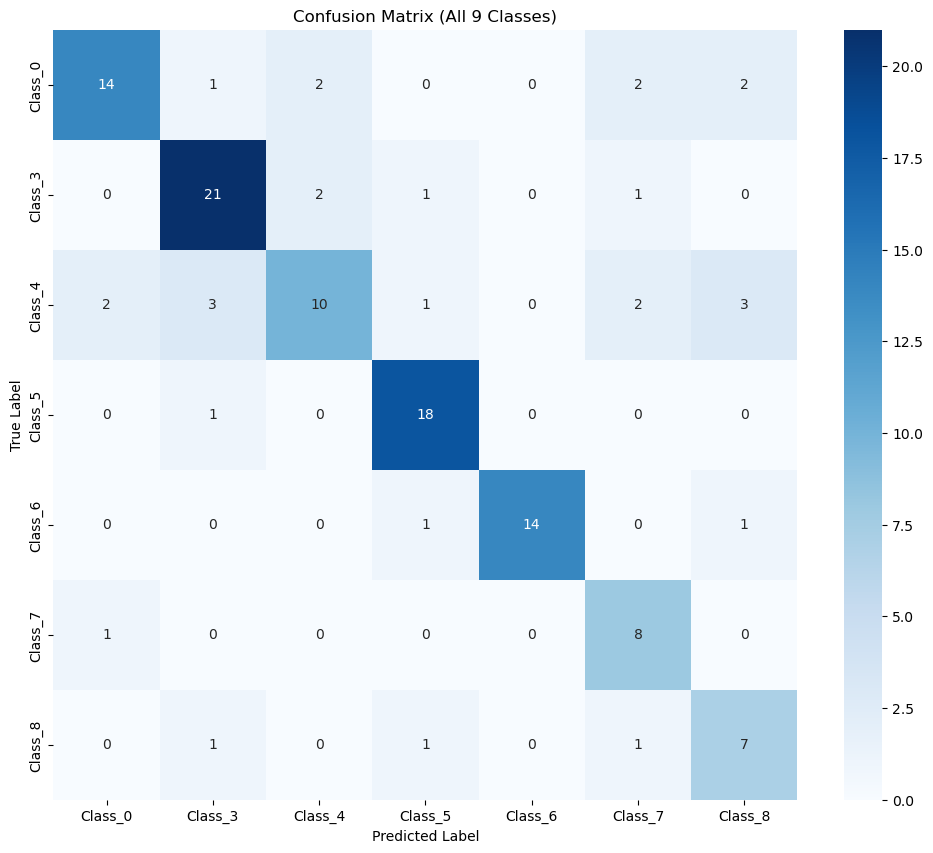

In [226]:
def analyze_complete_class_performance(model, loader, all_classes=[0, 3, 4, 5, 6, 7, 8]):
    """Analyze performance for ALL classes the model outputs"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for raw_batch, psd_batch, labels in loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device)
            
            outputs = model(raw_batch, psd_batch)
            _, preds = outputs.max(1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Use ALL classes that the model can predict (9 classes)
    # not just the ones that appear in this particular batch
    class_names = [f'Class_{i}' for i in all_classes]
    
    print("=== COMPLETE CLASS PERFORMANCE (9 classes) ===")
    print(classification_report(all_labels, all_preds, 
                               labels=all_classes,  # Force include all 9 classes
                               target_names=class_names, 
                               digits=4,
                               zero_division=0))  # Handle classes with no samples
    
    # Confusion matrix for all classes
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(all_labels, all_preds, labels=all_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (All 9 Classes)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # return all_preds, all_labels

# Run the complete analysis with ALL 9 classes
all_classes = [0, 3, 4, 5, 6, 7, 8]  # Your actual class labels
analyze_complete_class_performance(model, test_loader, all_classes)

In [227]:
# Verify the model is actually outputting 9 classes
def verify_model_output(model, loader):
    """Check that model outputs predictions for all 9 classes"""
    model.eval()
    
    with torch.no_grad():
        for raw_batch, psd_batch, labels in loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            
            outputs = model(raw_batch, psd_batch)
            
            print(f"Model output shape: {outputs.shape}")  # Should be (batch_size, 9)
            print(f"Number of classes: {outputs.shape[1]}")
            
            # Check if model can predict all 9 classes
            _, preds = outputs.max(1)
            unique_preds = sorted(torch.unique(preds).cpu().numpy())
            print(f"Unique predictions: {unique_preds}")
            
            break  # Just check first batch

verify_model_output(model, test_loader)

Model output shape: torch.Size([32, 9])
Number of classes: 9
Unique predictions: [0, 3, 4, 5, 6, 7, 8]
